In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [49]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

In [3]:
import requests
import json
from datetime import datetime
import time

In [4]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [5]:
from config import yelp_api_key
from config import darksky_api_key

## Set Up

In [190]:
# Analysis Dates
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-17' # End Date Exclusive

search_business = 'The Counting Room'
location = 'Brooklyn, NY'

## Pull Weather Data

In [191]:
host = 'https://api.yelp.com'
path = '/v3/businesses/search'

search_limit = 10

# Yelp Authorization Header with API Key
headers = {
        'Authorization': 'Bearer {}'.format(yelp_api_key) 
    }

# Build Requests Syntax with Yelp Host and Path and URL Paramaters
# Return JSON response
def request(host, path, url_params=None):
    
    url_params = url_params or {}
    url = '{}{}'.format(host, path)

    response = requests.get(url, headers=headers, params=url_params)
    
    return response.json()

# Build URL Params for the Request and provide the host and path
def search(term, location):
    
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit
    }
    
    return request(host, path, url_params=url_params)

# Return Coordinates if Exact Match Found
def yelp_lat_long(business, location):
    
    # Call search function here with business name and location
    response = search(business, location)
    
    # Set state to 'No Match' in case no Yelp match found
    state = 'No Match'
    possible_matches = []
    
    # Check search returns for match wtith business
    for i in range(len(response['businesses'])):

        # If match found:
        if response['businesses'][i]['name'] == business:

            # Local variables to help navigate JSON return
            response_ = response['businesses'][0]
            name_ = response_['name']

            print(f'Weather Location: {name_}')
            state = 'Match Found'
            #print(response['businesses'][0])
            return response_['coordinates']['latitude'], response_['coordinates']['longitude']

        else:
            
            # If no exact match, append all search returns to list
            possible_matches.append(response['businesses'][i]['name'])
    
    # If no match, show user potential matches
    if state == 'No Match':
        
        print('Exact match not found, did you mean one of the following? \n')
        
        for possible_match in possible_matches:
            print(possible_match)
            
        return None, None

lat, long = yelp_lat_long(search_business, location)

Weather Location: The Counting Room


### Darksky API Call

In [192]:
# Create List of Dates of target Weather Data
def find_dates(start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    return list_of_days

In [193]:
# Concatenate URL to make API Call
def build_url(api_key, lat, long, day):
    
    _base_url = 'https://api.darksky.net/forecast/'
    _time = 'T20:00:00'
    _url = f'{_base_url}{api_key}/{lat},{long},{day + _time}?America/New_York&exclude=flags'
    return _url

def make_api_call(url):
    
    r = requests.get(url)
    
    return r.json()

In [194]:
# Try / Except Helper Function for Handling JSON API Output
def find_val(dictionary, *keys):

    level = dictionary
    
    for key in keys:
        
        try:
            level = level[key]
            
        except:
            return np.NAN
        
    return level

# Parse API Call Data using Try / Except Helper Function
def parse_data(data):

    time = datetime.fromtimestamp(data['currently']['time']).strftime('%Y-%m-%d')
    
    try:
        precip_max_time = datetime.fromtimestamp(find_val(data, 'daily', 'data', 0, 'precipIntensityMaxTime')).strftime('%I:%M%p')
    
    except:
        precip_max_time = datetime(1900,1,1,5,1).strftime('%I:%M%p')
    
    entry = {'date': time,
             'temperature': float(find_val(data, 'currently', 'temperature')),
             'apparent_temperature': float(find_val(data, 'currently', 'apparentTemperature')),
             'humidity': float(find_val(data, 'currently', 'humidity')),
             'precip_intensity_max': float(find_val(data,'daily','data', 0, 'precipIntensityMax')),
             'precip_type': find_val(data, 'daily', 'data', 0, 'precipType'),
             'precip_prob': float(find_val(data, 'currently', 'precipProbability')),
             'pressure': float(find_val(data, 'currently', 'pressure')),
             'summary': find_val(data, 'currently', 'icon'),
             'precip_max_time': precip_max_time}
    
    return entry

In [195]:
# Create List of Weather Data Dictionaries & Input Target Dates
def weather_call(start_date, end_date, _lat, _long):
    
    weather = []
    list_of_days = find_dates(start_date, end_date)
    
    for day in list_of_days:
        
        data = make_api_call(build_url(darksky_api_key, _lat, _long, day))
    
        weather.append(parse_data(data))
    
    return weather

result = weather_call(start_date, end_date, lat, long)

In [196]:
# Build DataFrame from List of Dictionaries
def build_weather_df(api_call_results):

    df = pd.DataFrame(api_call_results)

    # Add day of week to DataFrame + Set Index as date
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    
    df.set_index('date', inplace=True)
    
    df['apparent_temperature'].fillna(method='ffill',inplace=True)
    df['temperature'].fillna(method='ffill',inplace=True)
    df['humidity'].fillna(method='ffill',inplace=True)
    df['precip_prob'].fillna(method='ffill', inplace=True)
    df['pressure'].fillna(method='ffill', inplace=True)
    df['precip_type'].fillna(value='none', inplace=True)
    
    return df

weather_df = build_weather_df(result);

In [197]:
weather_df.to_csv(f'weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'weather_{start_date}_to_{end_date}.csv'

## Import / Clean / Prep File

In [198]:
# Restaurant File
current_file = 'rest_1_dinner_sales_w_covers_061619.csv'

# Weather File
weather_csv_file = 'weather_2017-01-01_to_2019-06-17.csv'

In [199]:
# HELPER FUNCTION
def filter_df(df, start_date, end_date):
    
    return df[(df.index > start_date) & (df.index < end_date)]

In [200]:
# HELPER FUNCTION
def import_parse(file):

    data = pd.read_csv(file, index_col = 'date', parse_dates=True)
    df = pd.DataFrame(data)
    
    # Rename Column to 'sales'
    df = df.rename(columns={df.columns[0]: 'sales',
                           'dinner_covers': 'covers'})
    
    # Drop NaN
    #df = df.query('sales > 0').copy()
    df.fillna(0, inplace=True)
    
    print(f'"{file}" has been imported + parsed. The file has {len(df)} rows.')
    
    return df

In [201]:
# HELPER FUNCTION
def prepare_data(current_file, weather_file):
    
    df = filter_df(import_parse(current_file), start_date, end_date)
    weather_df_csv = pd.read_csv(weather_csv_file, parse_dates=True, index_col='date')
    weather_df_csv['summary'].fillna(value='none', inplace=True)
    
    df = pd.merge(df, weather_df_csv, how='left', on='date')
    
    return df

### Encode Closed Days

In [202]:
# Set Closed Dates using Sales & User Input

## CLOSED DATES
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-01-01', '2018-02-04', '2019-02-03']
closed_dates = [pd.to_datetime(date) for date in additional_closed_dates]

# Drop or Encode Closed Days
def encode_closed_days(df):

    # CLOSED FEATURE
    cal = calendar()

    # Local list of days with zero sales
    potential_closed_dates = df[df['sales'] == 0].index

    # Enocodes closed days with 1
    df['closed'] = np.where((((df.index.isin(potential_closed_dates)) & \
                              (df.index.isin(cal.holidays(start_date, end_date)))) | df.index.isin(closed_dates)), 1, 0)

    df['sales'] = np.where(df['closed'] == 1, 0, df['sales'])
    
    return df

### Impute Outliers in Data

In [203]:
 #Replace Outliers with Medians
## Targets for Outliers

z_thresh = 3

def impute_outliers(df, *col):
    
    # Check for Outliers in Sales + Covers
    for c in col:
        
        # Impute Median for Sales & Covers Based on Day of Week Outiers
        for d in df['day_of_week'].unique():
            
            # Median / Mean / STD for each day of the week
            daily_median = np.median(df[df['day_of_week'] == d][c])
            daily_mean = np.mean(df[df['day_of_week'] == d][c])
            daily_std = np.std(df[df['day_of_week'] ==d ][c])
            
            # Temporary column encoded if Target Columns have an Outlier
            df['temp_col'] = np.where((df['day_of_week'] == d) & (df['closed'] == 0) & ((np.abs(df[c] - daily_mean)) > (daily_std * z_thresh)), 1, 0)
            
            # Replace Outlier with Median
            df[c] = np.where(df['temp_col'] == 1, daily_median, df[c])
            df = df.drop(['temp_col'], axis=1)
        
    
    return df

### Add Per Person Average (PPA)

In [204]:
def add_ppa(df):
    
    df['ppa'] = np.where(df['covers'] > 0, df['sales'] / df['covers'], 0)
    
    return df

## Clean File Here

In [205]:
data = add_ppa(impute_outliers(encode_closed_days(prepare_data(current_file, weather_csv_file)), 'sales', 'covers'))

"rest_1_dinner_sales_w_covers_061619.csv" has been imported + parsed. The file has 896 rows.


## CHOOSE TARGET --> SALES OR COVERS

In [206]:
target = 'sales'

### Create Month Clusters

In [207]:
from sklearn.cluster import KMeans

day_k = 7
mo_k = 3

def create_clusters(df, target, col, k):
    
    # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
    describe = df.groupby(col)[target].aggregate(['median', 'std', 'max'])
    df = describe.reset_index()
    
    # SCALE TEMPORARY DF
    scaler = MinMaxScaler()
    f = scaler.fit_transform(df)
    
    # INSTANTIATE MODEL
    km = KMeans(n_clusters=k, random_state=0).fit(f)
    
    # GET KMEANS CLUSTER PREDICTIONS
    labels = km.predict(f)
    
    # MAKE SERIES FROM PREDICTIONS
    temp = pd.DataFrame(labels, columns = ['cluster'], index=df.index)
    
    # CONCAT CLUSTERS TO DATAFRAME
    df = pd.concat([df, temp], axis=1)
    
    # CREATE CLUSTER DICTIONARY
    temp_dict = {}
    for i in list(df[col]):
        
        temp_dict[i] = df.loc[df[col] == i, 'cluster'].iloc[0]
    
    return temp_dict

# Create Global Dictionaries to Categorize Day / Month
#day_dict = create_clusters(data, 'day_of_week', day_k)
month_dict = create_clusters(data, target, 'month', mo_k)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [208]:
# Print Clusters
print('Month Clusters: ', month_dict, '\n', 'Total Clusters: ', len(set(month_dict.values())))

Month Clusters:  {1: 2, 2: 2, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1} 
 Total Clusters:  3


### Add Temperature Onehot Categories

In [209]:
def encode_temp(df):

    temp_enc = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans')
    temp_enc.fit(df[['apparent_temperature']])
    
    return temp_enc
    
def one_hot_temp(df, temp_enc):
    
    binned_transform = temp_enc.transform(df[['apparent_temperature']])
    binned_df = pd.DataFrame(binned_transform.toarray(), index=df.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot', 'temp_very_hot'])
    df = df.merge(binned_df, how='left', on='date')
    df.drop(['apparent_temperature', 'temperature'], axis=1, inplace=True)

    return df, temp_enc

## Feature Engineering

In [210]:
# Add Clusters to DataFrame to use as Features
def add_clusters(df):
    
    #df['day_cluster'] = df['day_of_week'].apply(lambda x: day_dict[x]).astype('category')
    df['month_cluster'] = df['month'].apply(lambda x: month_dict[x]).astype('category')
    
    return df

### Add Weather Features

In [211]:
hours_start = '05:00PM'
hours_end = '11:59PM'

hs_dt = datetime.strptime(hours_start, "%I:%M%p")
he_dt = datetime.strptime(hours_end, "%I:%M%p")

def between_time(check_time):
        
    if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:

        return 1

    else:

        return 0

In [212]:
add_weather = True

temp_delta_window = 1

def add_weather_features(df):
    
    if add_weather:
        
        # POOR WEATHER FEATURES
        df['precip_while_open'] = df['precip_max_time'].apply(lambda x: between_time(x))
    
        # DROP FEATURES
        features_to_drop = ['precip_max_time']
        df.drop(features_to_drop, axis=1, inplace=True)
        
    return df

### Add Calendar Features

In [213]:
def add_cal_features(df):
    
    cal = calendar()

    # THREE DAY WEEKEND FEATURE
    sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
    df['sunday_three_day'] = np.where(df.index.isin(sunday_three_days), 1, 0)
    
    return df

### Add Dummies

In [214]:
def add_dummies(df):
    
    df['day_of_week'] = df['day_of_week'].astype('category')
    
    df = pd.get_dummies(data=df, columns=['day_of_week', 'month_cluster'])
    
    return df

### Add Interactions

In [215]:
def add_interactions(df):
    
    apply_this_interaction = False
    
    if apply_this_interaction:
        
        for d in [col for col in df.columns if col.startswith('day_of_week')]:
            
            for m in [col for col in df.columns if col.startswith('month_cluster')]:
                
                col_name = d + '_X_' + m
                
                df[col_name] = df[d] * df[m]
                
            df.drop([d], axis=1, inplace=True)
        
        df.drop([col for col in df.columns if col.startswith('month_cluster')], axis=1, inplace=True)
                
        return df
    
    else:
        
        return df

In [216]:
def add_weather_interactions(df):
    
    apply_this_interaction = True
    
    if apply_this_interaction:
        
        try:
            
            df['outside_X_precip_open'] = df['outside'] * df['precip_while_open']
            
            for w in [col for col in df.columns if col.startswith('temp_')]:

                col_name = w + '_X_' + 'outside'
                df[col_name] = df[w] * df['outside']

            df.drop(['outside'], axis=1, inplace=True)
            
        except:
            
            pass
        
        return df
    
    else:
        
        return df

### Feature Selection

In [217]:
def feature_selection(df):
    
    try:
        target_list = ['sales', 'covers', 'ppa']

        target_to_drop = [t for t in target_list if t != target]

        df = df.drop(target_to_drop, axis=1)
        
    except:
        pass
        
    # Feature Selection / Drop unnecessary or correlated columns
    cols_to_drop = ['month', 'precip_type', 'summary', 'pressure', 'precip_intensity_max','temp_warm', 'temp_warm_X_outside', 'day_of_week_0']
    
    df = df.drop(cols_to_drop, axis=1)
    
    return df

### Add Target Trend Feature Engineering

In [218]:
trend_days_rolling = 28
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

def target_trend_engineering(df):
    
    df['target_trend'] = df[target].rolling(trend_days_rolling).mean() / df[target].shift(trend_days_shift).rolling(trend_days_rolling).mean()
    #df['target_delta'] = df[target].shift(7) + df[target].shift(14) - df[target].shift(21) - df[target].shift(28)
        
    return df

## Start Here

In [219]:
# IMPORT & PARSE CLEAN TRAINING SET
data = add_ppa(impute_outliers(encode_closed_days(prepare_data(current_file, weather_csv_file)), 'sales', 'covers'));

"rest_1_dinner_sales_w_covers_061619.csv" has been imported + parsed. The file has 896 rows.


In [220]:
# One Hot Encode Temperature Data
data, temp_enc = one_hot_temp(data, encode_temp(data))

In [221]:
def feature_engineering(df):
    
    df.columns = df.columns.map(str)
    
    # Add day & Month Clusters // Dicts with data held in Global Variable
    df = add_clusters(df)
    
    # Add Engineered Features for Weather & Calendar
    df = add_weather_features(df)
    df = add_cal_features(df)
    
    # Create Dummies
    df = add_dummies(df)
    
    # Add Interactions
    df = add_interactions(df)
    df = add_weather_interactions(df)
    
    # Drop Selected Columns
    df = feature_selection(df)
    
    return df

dfx = feature_engineering(data)

In [222]:
dfx = target_trend_engineering(dfx)

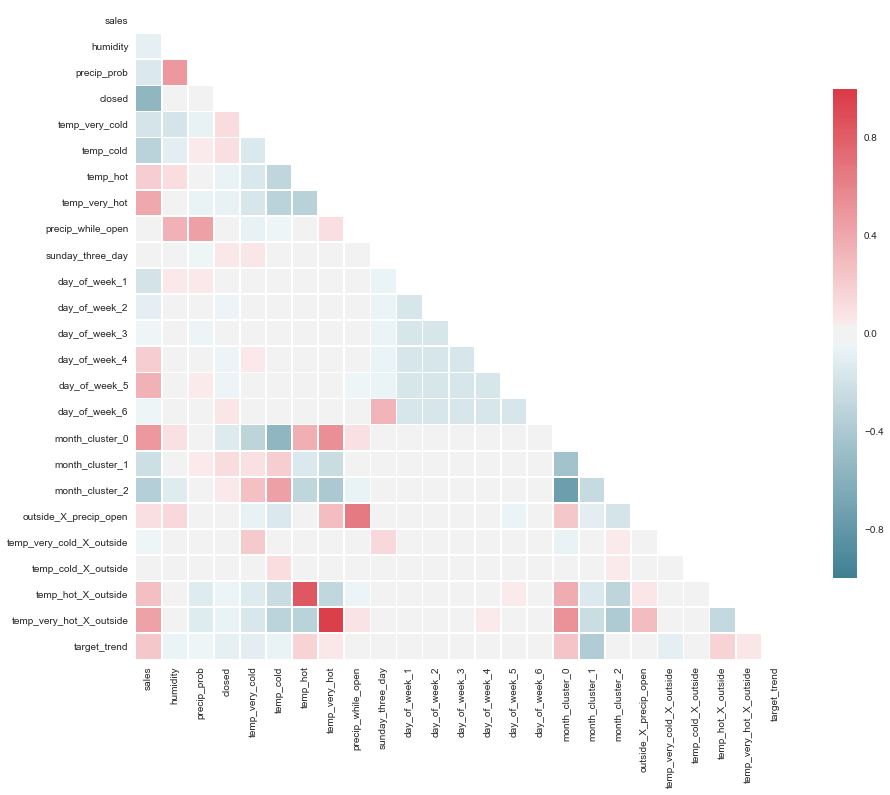

In [223]:
def corr_chart(df):
    
    corr = dfx.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
corr_chart(dfx)

## Train / Test / Split

In [224]:
def cv_split(df):
    
    features = dfx.drop([target], axis=1)[days_fwd:]
    y = dfx[target][days_fwd:]
    
    return features, y

cv_features, cv_y = cv_split(dfx)

In [225]:
def train_test_split(df):
    
    # Separate Target & Features
    y = df[target]
    features = df.drop([target], axis=1)
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = features[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    X_test = features[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    # Scale
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)
    
    print('Train set: ', len(X_train))
    print('Test set: ', len(X_test))
    
    return X_train, X_test, y_train, y_test, scaler
    
X_train, X_test, y_train, y_test, scaler = train_test_split(dfx)

Train set:  694
Test set:  167


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## XGB Regressor

In [226]:
# xgb1 = XGBRegressor()

# parameters = {'nthread':[4], 
#               'objective':['reg:linear'],
#               'learning_rate': [0.01, 0.02, 0.03], 
#               'max_depth': [3, 4, 5],
#               'min_child_weight': [1, 2, 3],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.55, 0.60, 0.65],
#               'n_estimators': [400, 500, 600]}

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 3,
#                         n_jobs = 5,
#                         verbose=True,
#                         scoring = 'neg_mean_squared_error')

# xgb_grid.fit(X_train,
#         y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

In [227]:
# Model Set Up
def xgb_model(X_train, y_train):
    
    objective = 'reg:linear'
    booster = 'gbtree'
    nthread = 4
    learning_rate = 0.02
    max_depth = 3
    colsample_bytree = 0.75
    n_estimators = 450
    min_child_weight = 2
    
    xgb_rgr= XGBRegressor(booster=booster, objective=objective, colsample_bytree=colsample_bytree, learning_rate=learning_rate, \
                                max_depth=max_depth, nthread=nthread, n_estimators=n_estimators, min_child_weight=min_child_weight, random_state = 0)
    
    xgb_rgr = xgb_rgr.fit(X_train, y_train)
    
    return xgb_rgr

In [228]:
# Run Model
xgb_rgr = xgb_model(X_train, y_train)

In [229]:
def tree_score(rgr, X_test, y_test, cv_features, cv_y):
    
    y_hat = rgr.predict(X_test)
    sum_squares_residual = sum((y_test - y_hat)**2)
    sum_squares_total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(sum_squares_residual))/sum_squares_total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Formula Scores:', '\n', 'Test R-Squared: ', r_squared,'\n', 'Test Adjusted R-Squared: ', adjusted_r_squared, '\n')
    
    print('Sklearn Metric Scores:')
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    pred_df = pd.DataFrame(y_pred, index=y_test.index)
    pred_df = pred_df.rename(columns={0: target})
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=10, scoring='r2')), '\n')
        
    return pred_df

pred_df = tree_score(xgb_rgr, X_test, y_test, cv_features, cv_y) 

Formula Scores: 
 Test R-Squared:  0.8350877160436759 
 Test Adjusted R-Squared:  0.8072152173468324 

Sklearn Metric Scores:
Train R-Squared:   0.8267201682818596
Test R-Squared:   0.8350877160436759 

Root Mean Squared Error:  1284.8469461949041 

Cross Val Avg R-Squared:  0.6641639934264594 



### RESIDUAL PLOT

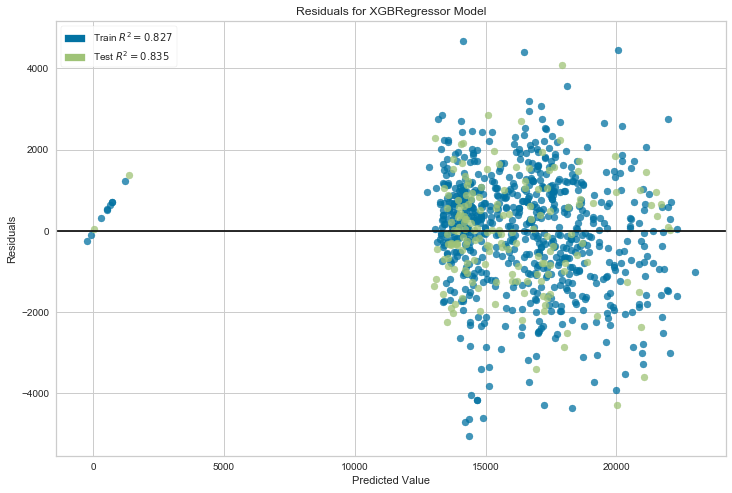

In [230]:
plt.figure(figsize=(12,8))

visualizer = ResidualsPlot(xgb_rgr, hist=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Feature Importance

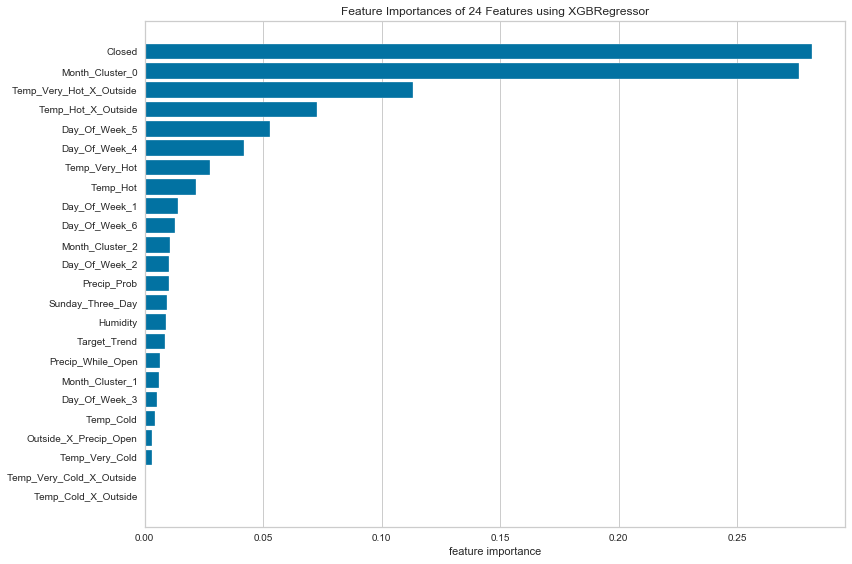

In [231]:
features = list(X_train.columns)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

labels = list(map(lambda x: x.title(), features))
visualizer = FeatureImportances(xgb_rgr, ax=ax, labels=labels, relative=False)

visualizer.fit(X_train, y_train)
visualizer.poof();

In [232]:
outside = 1

def predict_df(clf, scaler, X_train, current_df, date_1, date_2):
    
    # Find Lat Long for Business
    lat, long = yelp_lat_long(search_business, location)
    
    # Pull Weather Data / Forecast
    weather_df = build_weather_df(weather_call(date_1, date_2, lat, long))
    
    day_of_week, apparent_temperature = weather_df['day_of_week'], weather_df['apparent_temperature']
    weather_df['outside'] = outside
    
    # One Hot Encode Temperature Using Fitted Encoder
    df, _ = one_hot_temp(weather_df, temp_enc)
    
    df['closed'] = 0
    
    # Add Feature Engineering
    df = feature_engineering(df)
    
    # Add Sales Data for Sales Trend Engineering
    current_df = current_df[target]
    df = pd.merge(df, current_df, on='date', how='left')
    df[target] = df[target].fillna(method='ffill')
    
    df = target_trend_engineering(df)
    df = df.drop([target], axis=1)
    
    # Ensure Column Parity
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X_train.columns][-2:]
    
    # Scale Transform
    df_scaled = scaler.transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    # Predict and Build Prediction DataFrame for Review
    pred_array = pd.DataFrame(clf.predict(df), index=df.index, columns=[target])
    pred_df = df[df.columns[(df != 0).any()]]
    pred_df = pd.concat([pred_df, day_of_week, apparent_temperature], axis=1)
    
    final_predict = pd.concat([pred_array, pred_df], axis=1)
    
    return final_predict

In [233]:
tonight = predict_df(xgb_rgr, scaler, X_train, dfx, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

Weather Location: The Counting Room


,sales,humidity,precip_prob,temp_very_hot,day_of_week_1,month_cluster_0,temp_very_hot_X_outside,target_trend,day_of_week,apparent_temperature
date,,,,,,,,,,
2019-06-17,17511.994141,0.698630,0.00,1.0,0.0,1.0,1.0,0.424460,0,73.02
2019-06-18,15060.410156,0.863014,0.38,1.0,1.0,1.0,1.0,0.356883,1,71.39
